## Finite Element Method (FEM) discretization of the heat equation in two dimensions with FEniCS

<b>Goal</b>: This <a href="https://jupyter.org"> Jupyter</a> notebook aims at illustrating the use of FEniCS to discretize a time-dependent PDE (heat equation in two dimensions). We specifically learn how to define the problem inside FEniCS. 

<b>Note</b>: a cell is made active by first clicking on the left part of the web page (a blue vertical line appears) and then pushing Shift+Enter. 

<b>Note</b>: The next cell has to be activated only once and specifies the Python libraries we will use in this notebook. A basic knowledge of Python is only expected to understand the code used in the cells.  

In [1]:
#
# To allow plots within the Notebook 
#
%matplotlib inline

# Import here the standard Python libraries used in the Notebook
import matplotlib.pyplot as plt
import numpy as np
from scipy import *
import scipy.sparse as sps
import sys
import time

# Import FEniCS related libraries
from fenics import *
import dolfin as df

### Python version

In [2]:
print(sys.version)

3.7.3 | packaged by conda-forge | (default, Mar 27 2019, 15:43:19) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


### <a href="https://fenicsproject.org">FEniCS</a> version 

In [3]:
print(df.__version__)

2019.1.0


### <a href="https://fenicsproject.org">Scipy</a> Linear algebra libraries

In [4]:
print(show_config())

mkl_info:
  NOT AVAILABLE
lapack_mkl_info:
  NOT AVAILABLE
openblas_lapack_info:
    libraries = ['blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack']
    library_dirs = ['/Users/vasseur/Software/anaconda3/envs/fenicsproject/lib']
    language = f77
lapack_opt_info:
    libraries = ['blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack']
    library_dirs = ['/Users/vasseur/Software/anaconda3/envs/fenicsproject/lib']
    language = f77
blas_mkl_info:
  NOT AVAILABLE
system_info:
  NOT AVAILABLE
openblas_info:
    libraries = ['blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack']
    library_dirs = ['/Users/vasseur/Software/anaconda3/envs/fenicsproject/lib']
    language = f77
blas_opt_info:
    libraries = ['blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack']
    library_dirs = ['/Users/vasseur/Software/anaconda3/envs/fenicsproject/lib']
    language = f77
None


# A.  2D heat equation:


We consider the two-dimensional heat equation defined for all $t\ge 0$ as
$$
\begin{array}{ll} 
    \displaystyle \frac{\partial}{\partial t} u(t,\boldsymbol x) - \text{div}\Big(\overline{\overline k}(\boldsymbol x)\cdot {grad} \ u(t,\boldsymbol x)\Big)&=& f , \quad \boldsymbol x \in \Omega, \\
                  u(t,\boldsymbol x) & = & u_D, \quad \boldsymbol x \in \Gamma_D, \\ 
     {\partial_n} u(t,\boldsymbol x) & = & u_N, \quad \boldsymbol x \in \Gamma_N, \\ 
    u(0, \boldsymbol x) & = & u_0(x), \quad \boldsymbol x \in \Omega, t=0,  \\
\end{array}
$$
with $\Omega \subset \mathbb{R}^2$ an open bounded spatial domain with Lipschitz-continuous boundary $\delta \Omega = \Gamma_D \cup \Gamma_N$. 

$u(t,\boldsymbol x)$ denotes the temperature from the equilibrium position at point $\boldsymbol x \in \Omega $ and time $t$.  $\overline{\overline k} \in L^{\infty}(\Omega)$ (symmetric and coercive) denotes the conductivity coefficient. 


<b>Structure of part A</b>: This notebook first defines the continuous problem by using specific routines of FEniCS. Then we tackle the finite element discretization in space of the PDE. This discretization leads to a ODE formulation. After time discretization, we perform a numerical simulation to obtain an approximation of the space-time solution. Finally a simple postprocessing is performed. 

### Constants and parameters 

In [5]:
#
# Define constants related to the definition of the geometric rectangular domain
# x0, y0 are the coordinates of the bottom left point of the rectangle
# xL, yL are the coordinates of the top right point of the rectangle
#
x0, xL, y0, yL = 0., 2., 0., 1.
#
# Define constants related to the time discretization in [tinit,tfinal]
#
tinit  = 0.
tfinal = 4.
#
# Define the parameters related to the time discretization [only required for the Crank-Nicolson scheme]
# 
dt     = 5.e-2
theta  = 0.5
#
# Number of rectangles to be used in each direction for the mesh construction
#
nx = 20
ny = 20
#
# Degree of Lagrange approximation in space
#
deg = 2 
#
# Specify if the solution has to be stored in a VTK file for post-processing with Paraview
#
movie = False
if movie: vtkfile = File("./heat.pvd")
#
# Parameters related to the manufactured solution 
#
alpha = 3.
beta  = 0.

### FEniCS expressions definition

In [6]:
#
# Define Fenics Expressions or Constants
#

# Piecewise constant conductivity coefficient, with possibly a high conductivity in a subrectangle
# To specify k we use a FEniCS Expression which expresses the formula in terms of the coordinates
# of the point. The expression is a string that is parsed by a C++ compiler and so must be written in C++.
# DOLFIN_EPS is the machine precision used in FEniCS.
# Here we specify two different subdomains and may assign different values depending on the location. 
# degree is the degree of quadrature to be used later for k in the assembly process. 
k = Expression("x[0] > .5 - DOLFIN_EPS && x[0] < 1.25 + DOLFIN_EPS && x[1] < .75 + DOLFIN_EPS && x[1] > .5 - DOLFIN_EPS ? 1. : 1.", degree=2)

# Source term
# We use a Constant here due to the definition of the source term 
# that is related to the manufactured solution 
f = Constant(beta + 2 + 2*alpha)

#
# Dirichlet boundary condition on Gamma_D 
#
u_D = Expression('x[0]*(Lx-x[0]) + alpha*x[1]*(Ly-x[1]) + beta*t',
                  degree=2, Lx= xL, Ly = yL, alpha=alpha, beta=beta, t=0)

#
# Neumann boundary condition on Gamma_N 
#
# u_N = Constant(0.)
u_N = Expression('alpha*(1.-2.*x[1])',
                  degree=2, alpha=alpha)
#
# Initial condition at time = tinit [u_D at time equal to 0]
#
u_0 = Expression("x[0]*(Lx-x[0]) + alpha*x[1]*(Ly-x[1])", degree=2, alpha=3., Lx= xL, Ly = yL)

### Problem at the continuous level

In [7]:
#
# Specify here the definition of the part of the boundary related to the Dirichlet boundary condition
#

only_Dirichlet = False

def Gamma_D(x, on_boundary):
    """
    This function should return a boolean value equal to true or false according to whether the point x 
    belongs to Gamma_D or not. 
    """
    if only_Dirichlet:
        return on_boundary
    else:
        return near(x[1], DOLFIN_EPS) or near(x[0], DOLFIN_EPS) or near(x[0], 2.) and on_boundary

### Problem at the discrete level in space and time

Time spent in the meshing procedure:  0.000801477000000439
Time spent in the finite element assembly procedure:  0.05605333899999998


Text(0.5, 1.05, 'Sparsity pattern of the implicit matrix')

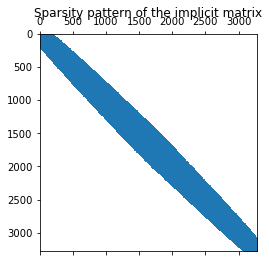

In [8]:
#
# Finite Element Space and Time discretization of the weak formulation
# 

# Generate the computational mesh 
# Here is the simplest way to discretize a rectangular domain with nx and ny rectangles in directions x and y,
# respectively. 
# The 'crossed' argument specifies that each rectangle will be divided into four triangles. 

meshing_start         = time.perf_counter()
mesh                  = RectangleMesh(Point(x0,y0), Point(xL,yL), nx, ny,'crossed')
meshing_time          = time.perf_counter()-meshing_start

# If the domain is the unit square, you may want to use instead
# mesh = UnitSquareMesh(nx, ny, 'crossed')
    
# Select the FE approximation space of Lagrange type
V = FunctionSpace(mesh, "Lagrange", deg)
 
# Specify the Dirichlet boundary conditions 
bc = DirichletBC(V, u_D, Gamma_D)

#
# Define initial value or previous value 
#
u_n = interpolate(u_0, V)

#    
# Discretization in space of the weak formulation 
#
assembly_start = time.perf_counter()

u = TrialFunction(V)
v = TestFunction(V)

#
# Complete variational formulation corresponding to the theta-scheme
#
# Simplification here due to a time-independent term for the source terms ! 
#

F = u*v*dx + theta*dt*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx + \
    (1.-theta)*dt*dot(grad(u_n), grad(v))*dx - dt*u_N*v*ds
#
# Deduce the bilinear and linear forms
#

a, L   = lhs(F), rhs(F)
A,b    = assemble_system(a,L,bc)

assembly_time = time.perf_counter()-assembly_start


#
# Timings
#

print("Time spent in the meshing procedure: ",meshing_time)
print("Time spent in the finite element assembly procedure: ",assembly_time)

#
# Sparsity pattern of B
# 
plt.figure()
plt.spy(sps.csr_matrix(A.array()))
plt.title("Sparsity pattern of the implicit matrix")

### Numerical approximation of the space-time solution

In [9]:
#
# Numerical Approximation of the space-time solution
#
t     = tinit
tstep = 0


# Store the initial condition if required
u_n.rename("u", "Temperature") 
if movie: vtkfile << u_n

#
# Time-integration 
#
u = Function(V, name="u")
#
# Define which type of iterative solver we want to use
#
#solver                                   = PETScKrylovSolver('cg','hypre_amg')
#solver.ksp().setGMRESRestart(restart)
#restart                                  = 20
solver                                    = LUSolver(A)
#solver                                    = PETScLUSolver('mumps')
#solver.parameters['reuse_factorization']  = True 
#solver.parameters["monitor_convergence"] = True
#solver.parameters['relative_tolerance']  = 1e-3


while t + dt <= tfinal:
    t     += dt
    tstep += 1
    u_D.t  = t
        
    # Solve the linear system to obtain the approximation of the solution at time t
    # We use assemble_system to keep symmetry
    A, b = assemble_system(a, L, bc)
    
    
    # We call the specific solver here
    solver.solve(A,u.vector(),b)
    
    # Store the current solution if required
    if movie: vtkfile << u
    
    # Compute error at vertices
    #if only_Dirichlet:
    u_e   = interpolate(u_D, V)
    error = np.abs(u_e.vector() - u.vector()).max()
    print('t = %.2f: error = %.3g' % (t, error))
  
    # Prepare the next iteration in time 
    u_n.assign(u)
    
    # Monitor the time integration
    if tstep%10 == 0:
       print("Timestep %g"% tstep, "Time %2.3e" %t)

t = 0.05: error = 8.57e-14
t = 0.10: error = 1.15e-13
t = 0.15: error = 1.73e-13
t = 0.20: error = 1.9e-13
t = 0.25: error = 2.34e-13
t = 0.30: error = 2.41e-13
t = 0.35: error = 2.73e-13
t = 0.40: error = 2.73e-13
t = 0.45: error = 2.97e-13
t = 0.50: error = 2.92e-13
Timestep 10 Time 5.000e-01
t = 0.55: error = 3.11e-13
t = 0.60: error = 3.03e-13
t = 0.65: error = 3.2e-13
t = 0.70: error = 3.1e-13
t = 0.75: error = 3.25e-13
t = 0.80: error = 3.15e-13
t = 0.85: error = 3.28e-13
t = 0.90: error = 3.17e-13
t = 0.95: error = 3.3e-13
t = 1.00: error = 3.19e-13
Timestep 20 Time 1.000e+00
t = 1.05: error = 3.3e-13
t = 1.10: error = 3.2e-13
t = 1.15: error = 3.31e-13
t = 1.20: error = 3.21e-13
t = 1.25: error = 3.31e-13
t = 1.30: error = 3.22e-13
t = 1.35: error = 3.31e-13
t = 1.40: error = 3.23e-13
t = 1.45: error = 3.32e-13
t = 1.50: error = 3.23e-13
Timestep 30 Time 1.500e+00
t = 1.55: error = 3.31e-13
t = 1.60: error = 3.24e-13
t = 1.65: error = 3.32e-13
t = 1.70: error = 3.24e-13
t = 1.7

### Post-processing

3281


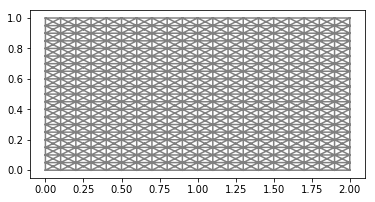

In [10]:
#
# We plot the finite element mesh
# 
print(u.vector().size())
plot(mesh)

Text(0.5, 1.0, 'Solution of the heat equation at final time')

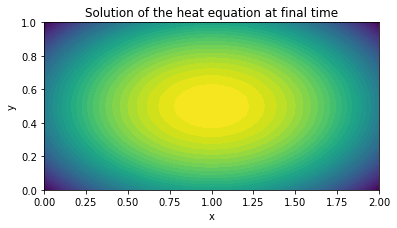

In [11]:
#
# A very basic post-processing
# We plot the solution at final time
#
plt.figure()
plot(u)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Solution of the heat equation at final time')
#
# If movie=True, paraview can be used to read the file (evolution of the solution versus time)
#

### Feedback / Your comments or notes

# Further information

- <a href="https://fenicsproject.org">FEniCS website</a>. 

- <a href="https://fenicsproject.org/tutorial">FEniCS tutorials</a>.